In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict

# https://www.reddit.com/r/pushshift/comments/w23fg5/gaps_in_rs_submission_dumps_can_anyone_confirm/
# https://www.reddit.com/r/food/comments/exg935/a_massive_rule_overhaul/
# https://www.reddit.com/r/food/comments/rhok28/announcement_new_titles_rules_are_going_to_be/


Bad key text.latex.preview in file /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably need to 

Rule changes:
 - "Please describe the food in the title" https://www.reddit.com/r/food/comments/3vvk91/mod_post_rule_clarification_we_require/
 - "Going forward, all link posts must have "only one" of the following tags" - with tag dscription
     - https://www.reddit.com/r/food/comments/56nlo5/mod_post_psa_update_please_see_the_following_rule/
 - announced in february 2020 (tags, 100% of titles need to be food, etc.)
        - https://www.reddit.com/r/food/comments/exg935/a_massive_rule_overhaul/
        - when did they take effect?
 - new title rules (70% of title = food only. Take effect December 2021)
        - https://www.reddit.com/r/food/comments/rhok28/announcement_new_titles_rules_are_going_to_be/
 - post flairs were gone but came back in June 2020: https://www.reddit.com/r/food/comments/gwsbg9/post_flairs_are_back/

70% of the title has to specifically describe what the food is. Backstory to the food / where the ingredients come from do not fall within the 70%. Use a comment on the post for backstory. No ALL CAPS, emojis or NON-OC Add a Tag at the Front of Your Title: * [I ate] - food you ate in a restaurant * [Homemade] - food you made at home * [Pro/Chef] - food you made if you work in the food industry

In [3]:
df_subs = pd.read_json('../../data/RedditCrawl/202204/wellbeing/submissions/food/food_submissions.txt', lines=True)
df_subs_food = df_subs[df_subs.subreddit == 'food']

In [ ]:
df_subs_posts['date_utc'] = pd.to_datetime(df_subs_posts.created_utc, unit='s')

In [4]:
# without deleted authors
reg_str = '\[ *(i ?(ate|eat)|home[ -]?made|pro[/ ]chef) *\]'

df_subs_posts = df_subs_food.copy()
print('All posts ever', len(df_subs_posts))

df_subs_posts['date_utc'] = pd.to_datetime(df_subs_posts.created_utc, unit='s')
df_subs_posts['date_day'] = df_subs_posts['date_utc'].dt.date
df_subs_posts = df_subs_posts[(df_subs_posts.date_utc >= pd.to_datetime('2017-01-01')) & (df_subs_posts.date_utc <= pd.to_datetime('2021-01-01'))]

print('>2017', len(df_subs_posts))
df_subs_posts_norem = df_subs_posts[~(df_subs_posts.title.isin(['[removed]', '[deleted]', '[deleted by user]']) | pd.isna(df_subs_posts.title) | df_subs_posts.author.str.lower().isin(['[automoderator]']))].copy()
print('Removed and deleted posts', len(df_subs_posts_norem))

df_subs_posts_norem_nodup = df_subs_posts_norem.drop_duplicates(subset=['author', 'title', 'date_day'], keep='last')
print('Remove duplicates', len(df_subs_posts_norem_nodup))

df_sub_regex_posts = df_subs_posts_norem_nodup[df_subs_posts_norem_nodup.title.str.lower().str.contains(reg_str, regex=True)].copy()
df_sub_nonregex_posts = df_subs_posts_norem_nodup[~df_subs_posts_norem_nodup.title.str.lower().str.contains(reg_str, regex=True)].copy()

print('Matched Regex', len(df_sub_regex_posts))

df_sub_regex_posts['clean_title'] = df_sub_regex_posts.title.str.lower().str.replace('&amp;', ' and ', regex=False)
df_sub_regex_posts['clean_title'] = df_sub_regex_posts.clean_title.str.replace('\[.+?\]', ' ', regex=True).str.replace('( )+', ' ', regex=True).str.strip()

df_filtered = df_sub_regex_posts[df_sub_regex_posts.clean_title.str.len() >= 3]
print('Remaining after stripping empty', len(df_filtered))

df_filtered_nodel = df_filtered[~pd.isna(df_filtered.author) & ~df_filtered.author.isin(['[removed]', '[deleted]', '[AutoModerator]'])]
print('Remaining after removing deleted users', len(df_filtered_nodel))

All posts ever 1303769
>2017 757009
Removed and deleted posts 756253
Remove duplicates 748194


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


Matched Regex 512943
Remaining after stripping empty 512261
Remaining after removing deleted users 400962


In [1689]:
val_counts = df_filtered_nodel.author.value_counts()

In [1690]:
author_counts = df_filtered_nodel.author.value_counts()

In [1702]:
np.savetxt('food_data/authors_min_3.txt', author_counts[author_counts >= 3].index.values, '%s', delimiter='NODELIMPLEASE')

In [2109]:
df_filtered_nodel[(df_filtered_nodel.date_utc >= pd.to_datetime('2017-01-01')) & (df_filtered_nodel.date_utc < pd.to_datetime('2018-01-01'))]

Americanmalayalee    227
shomali11            185
jasmin6391           144
MissMollyMakes       120
davestarr            109
                    ... 
OfficerBonasera        1
ddexel                 1
Dasupalouie            1
didnotcutthebaby       1
tootsmefroots          1
Name: author, Length: 39914, dtype: int64

In [2170]:
authors_17 = df_filtered_nodel[(df_filtered_nodel.date_utc >= pd.to_datetime('2017-01-01')) & (df_filtered_nodel.date_utc < pd.to_datetime('2018-01-01'))].author.value_counts()
authors_17 = authors_17[(authors_17 >=3)]#& (authors_17 <= 50)]
print('2017 authors with 3 posts', len(authors_17))
authors_18 = df_filtered_nodel[(df_filtered_nodel.date_utc >= pd.to_datetime('2018-01-01')) & (df_filtered_nodel.date_utc < pd.to_datetime('2019-01-01'))].author.value_counts()
authors_18 = authors_18[(authors_18 >=3)]#& (authors_18 <= 50)]
print('2018 authors with 3 posts', len(authors_18))
authors_19 = df_filtered_nodel[(df_filtered_nodel.date_utc >= pd.to_datetime('2019-01-01')) & (df_filtered_nodel.date_utc < pd.to_datetime('2020-01-01'))].author.value_counts()
authors_19 = authors_19[(authors_19 >=3)]#& (authors_19 <= 50)]
print('2019 authors with 3 posts', len(authors_19))
authors_20 = df_filtered_nodel[(df_filtered_nodel.date_utc >= pd.to_datetime('2020-01-01')) & (df_filtered_nodel.date_utc < pd.to_datetime('2021-01-01'))].author.value_counts()
authors_20 = authors_20[(authors_20 >=3)]#& (authors_20 <= 50)]
print('2020 authors with 3 posts', len(authors_20))

2017 authors with 3 posts 5831
2018 authors with 3 posts 6331
2019 authors with 3 posts 7421
2020 authors with 3 posts 12344


In [2159]:
len(set(authors_17.index) & set(authors_18.index) & set(authors_19.index)& set(authors_20.index))

304

In [2152]:
all_authors_years = set(authors_17.index) | set(authors_18.index) | set(authors_19.index) | set(authors_20.index)

In [2171]:
filter_3posts = df_filtered_nodel.author.isin(set(author_counts[author_counts >= 3].index.values))

In [2172]:
filter_3posts_years = df_filtered_nodel.author.isin(all_authors_years)

In [2173]:
filters_authors = ( (df_filtered_nodel.author.isin(set(authors_17.index)) & (df_filtered_nodel.date_utc >= pd.to_datetime('2017-01-01')) & (df_filtered_nodel.date_utc < pd.to_datetime('2018-01-01'))) |
                    (df_filtered_nodel.author.isin(set(authors_18.index)) & (df_filtered_nodel.date_utc >= pd.to_datetime('2018-01-01')) & (df_filtered_nodel.date_utc < pd.to_datetime('2019-01-01'))) |
                    (df_filtered_nodel.author.isin(set(authors_19.index)) & (df_filtered_nodel.date_utc >= pd.to_datetime('2019-01-01')) & (df_filtered_nodel.date_utc < pd.to_datetime('2020-01-01'))) |
                    (df_filtered_nodel.author.isin(set(authors_20.index)) & (df_filtered_nodel.date_utc >= pd.to_datetime('2020-01-01')) & (df_filtered_nodel.date_utc < pd.to_datetime('2021-01-01')))
                  )

In [2167]:
np.sum(filters_authors)

217357

In [2163]:
np.sum(filters_authors)

198472

In [951]:
df_recipes = df_filtered[df_filtered.link_flair_text.fillna('').str.lower().str.contains('recipe')]

In [5]:
df_tag = df_subs_posts[df_subs_posts.title.str.lower().str.contains('\[.+?\]')]
print('comparison: Posts with any tag in title', len(df_tag))

comparison: Posts with any tag in title 544412


In [ ]:
df_filtered_nodel[df_filtered_nodel.author.isin(set(author_counts[author_counts >= 3].index.values))]

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(25, 6), sharex=True)
bins=250
df_subs_posts.date_utc.dt.date.hist(bins=bins, ax=ax, label='All posts')
df_subs_posts_norem.date_utc.dt.date.hist(bins=bins, ax=ax, label='No removed/deleted/Automoderator')
df_subs_posts_norem_nodup.date_utc.dt.date.hist(bins=bins, ax=ax, label='No removed/deleted/Automoderator and no duplicates')
#ax[0].set_ylabel('All food posts\n(including removed posts)')
df_tag.date_utc.dt.date.hist(bins=bins, ax=ax, label='Posts with any tag')
df_filtered.date_utc.dt.date.hist(bins=bins, ax=ax, label='Filtered posts (tag regex, removed posts)')
#ax[1].set_ylabel('Filtered posts\n(regex, removed posts)')
df_filtered_nodel.date_utc.dt.date.hist(bins=bins, ax=ax, label='Filtered posts (tag regex, removed posts + deleted users)')
df_filtered_nodel[filter_3posts].date_utc.dt.date.hist(bins=bins, ax=ax, label='Filtered posts (Users >3 posts)')
df_filtered_nodel[filter_3posts_years].date_utc.dt.date.hist(bins=bins, ax=ax, label='Filtered posts (Users >3 posts per year)')
df_filtered_nodel[filters_authors].date_utc.dt.date.hist(bins=bins, ax=ax, label='Filtered posts (Users >3 posts per year only posts in that year)')

#ax[2].set_ylabel('Filtered posts\n(regex, removed posts & users)')
ax.legend(loc='upper left')

In [1765]:
def extract_food_data(path, food_db):
    data_struct = []
    with open(path, 'r') as myfile:
        data = json.load(myfile)[food_db]

    units = defaultdict(set)
    for food_item in data:
        food_data = {}
        food_data['name'] = food_item['description']

        food_data['parent_name'] = food_item['wweiaFoodCategory']['wweiaFoodCategoryDescription'] if food_db == 'SurveyFoods' else food_data['name']
        for nutrient_info in food_item['foodNutrients']:
            if 'amount' in nutrient_info:
                if nutrient_info['nutrient']['name'] == 'Energy':
                        if nutrient_info['nutrient']['unitName'] == 'kcal':
                            food_data[nutrient_info['nutrient']['name']] = nutrient_info['amount']
                            units[nutrient_info['nutrient']['name']].add(nutrient_info['nutrient']['unitName'])

                else:
                    food_data[nutrient_info['nutrient']['name']] = nutrient_info['amount']
                    units[nutrient_info['nutrient']['name']].add(nutrient_info['nutrient']['unitName'])
            else:
                #print(nutrient_info)
                pass # No info available
        data_struct.append(food_data)
    return pd.DataFrame(data_struct), units

# Nutritient info:
- https://www.nzdl.org/cgi-bin/library.cgi?e=d-00000-00---off-0mhl--00-0----0-10-0---0---0direct-10---4-------0-1l--11-en-50---20-about---00-0-1-00-0-0-11-1-0utfZz-8-00&a=d&c=mhl&cl=CL1.1&d=HASHc5831578d1d2af498d537a.5.2.4

# Foundation Food Field Description
https://fdc.nal.usda.gov/docs/Foundation_Foods_Documentation_Apr2020.pdf
Foundation Foods does not provide data on all nutrients. This is because of the uniqueness of the
data: 
- Some nutrients are not found in certain foods (e.g., cholesterol in plant foods, protein in oils).
- Some nutrients in a food have not yet been analyzed. Data analyses are continually conducted
and as data on nutrients are obtained, values will be added to food profiles.

### Proximate fields
“Proximate component” refers to the following macronutrients: water (moisture), protein, total lipid
(fat), total carbohydrate, and ash. Except for a few food items, nutrient profiles contain values for the
proximate components and at least one other nutrient
- Carbohydrate content, referred to as “carbohydrate by difference” in the tables, is expressed as the
difference between 100 and the sum of the percentages of water, protein, total lipid (fat), ash, and
alcohol (when present). - **PERCENTAGE**
-“Sugars, total NLEA” refers to the sum of the values for individual monosaccharides (galactose, glucose,
and fructose) and disaccharides (sucrose, lactose, and maltose), which are those sugars analyzed for
nutrition labelling. Because the analyses of total dietary fiber, total sugars, and starch content are
conducted separately and reflect the analytical variability inherent in the measurement process, the
sum of these carbohydrate fractions may not equal the carbohydrate-by-difference value or may even
exceed it
- Food energy is expressed in kcal and kJ. One kcal equals 4.184 kJ. The data represent physiologically
available energy, which is the value remaining after digestive and urinary losses are deducted from gross
energy (Merrill and Watt, 1973). Most energy values are calculated using the default factors of 4, 9, and
4 for protein, fat, and carbohydrates, respectively. Calorie factors for protein, fat, and carbohydrates are
included in the Food Descriptions table for many food items. For foods containing alcohol, a factor of 6.93 is used to calculate kcal/g of alcohol (Merrill and Watt, 1973)
- Vitamins reported in the database include ascorbic acid, thiamin, riboflavin, niacin, pantothenic acid,
vitamin B 6, vitamin B 12, folate, choline, vitamin A, vitamin D, vitamin E, and vitamin K. Many of the values
were obtained in small sample sizes, often of composited samples.
- "Protein". The values for protein are calculated from the amount of total nitrogen in the food using the nitrogen-
to-protein conversion factors recommended by Jones (1941) for most food items. The factor applied
to each food item is provided in the NFactor field in the Food Description table. Values in Foundation Foods are now listed as “calculated.” This differs from the approach taken in SR
Legacy, which denotes protein as “analytical.”
- Lipid component. Fatty acid values are expressed in g per 100 g of food. Logically, the sum of the fatty acids may not add
up to the value for total lipid. Total lipid values used on food labels represent the amount of triglyceride
that would produce the amount of lipid fatty acids determined using gas chromatography, as required
by the NLEA.

In [922]:
# https://fdc.nal.usda.gov/fdc-app.html#/food-details/2341748/nutrients

In [1766]:
foundation_data, foundation_units = extract_food_data('food_data/FoodData_Central_foundation_food_json_2022-10-28.json', food_db='FoundationFoods')
foundation_data['data_source'] = 'foundation'
survey_data, survey_units = extract_food_data('food_data/FoodData_Central_survey_food_json_2022-10-28.json', food_db='SurveyFoods')
survey_data['data_source'] = 'survey22'
survey_21_data, survey_21_units = extract_food_data('food_data/FoodData_Central_survey_food_json_2021-10-28.json', food_db='SurveyFoods')
survey_21_data['data_source'] = 'survey21'
legacy_data, legacy_units = extract_food_data('food_data/FoodData_Central_sr_legacy_food_json_2021-10-28.json', food_db='SRLegacyFoods')
legacy_data['data_source'] = 'legacy'

In [2206]:
food_data_all = pd.concat([foundation_data, survey_data, survey_21_data, legacy_data])
food_data_all['bow'] = food_data_all.name.str.split(', ')
food_data_all = food_data_all.drop_duplicates(subset='name')
food_data_all['title_simple'] = food_data_all.name.str.replace('[,]+', ' ', regex=True).str.replace('( )+', ' ', regex=True).str.lower()
food_data_all['title_simple_reversed'] = food_data_all.name.str.lower().str.split(', ').apply(lambda l: ' '.join(list(reversed(l))))

food_data_cooked = food_data_all[~food_data_all.name.str.contains(' raw| uncooked| unheated') & 
                                 ~pd.isna(food_data_all.Energy)]

# spacy analysis

In [10]:
import spacy

In [11]:
nlp = spacy.load("en_core_web_lg")

In [217]:
nlp_tf = spacy.load("/home/jovyan/en_vectors_floret_lg")

In [351]:
spacy_nlp_foundation_data_dict = {title: nlp(title) for title in food_data_cooked[food_data_cooked.data_source=='foundation'].title_simple}
spacy_nlp_tf_foundation_data_dict = {title: nlp_tf(title) for title in food_data_cooked[food_data_cooked.data_source=='foundation'].title_simple}

In [1006]:
spacy_nlp_data_dict = {title: spacy_obj for title, spacy_obj in spacy_nlp_data_dict.items() if spacy_obj.vector.any()}
spacy_nlp_tf_data_dict = {title: spacy_obj for title, spacy_obj in spacy_nlp_tf_data_dict.items() if spacy_obj.vector.any()}

In [ ]:
spacy_nlp_foundation_data_dict = {title: spacy_obj for title, spacy_obj in spacy_nlp_foundation_data_dict.items() if spacy_obj.vector.any()}
spacy_nlp_tf_foundation_data_dict = {title: spacy_obj for title, spacy_obj in spacy_nlp_tf_foundation_data_dict.items() if spacy_obj.vector.any()}

In [12]:
test_data = pd.read_csv('food_data/new_sampled_food_nutrition.csv', index_col=0)

In [13]:
sample_nlp = {title: nlp(title) if not pd.isna(title) else np.nan for title in test_data.clean_title}

In [1007]:
def convert_nouns_to_lemmas(span):
    tokens_new = []
    curr_i = 0
    for token in span:
        if token.text == '-':
            continue
        elif token.pos_ == 'NOUN':
            tok_str = token.lemma_
            tokens_new.append(tok_str)
        elif token.pos_ in ['PART', 'PUNCT']:
            if curr_i == 0:
                continue
            tokens_new[curr_i-1] += token.text
            curr_i -= 1
        else:
            tok_str = token.text
            tokens_new.append(tok_str)
        curr_i += 1
    return nlp(' '.join(tokens_new))

def lookup_nutrition(span, df_food=food_data_cooked):
    # think about single words!!!
    
    # full match
    df_match = pd.DataFrame()
    full_match = span.text in df_food.title_simple
    if np.any(full_match):
        df_match = df_food[full_match]
    
    # partial match
    word_strings = []
    curr_i = 0
    for word in span:
        if word.pos_ == 'PART':
            if curr_i == 0:
                continue
            word_strings[curr_i-1] += word.text
        word_strings.append(word.text)
        curr_i += 1
    partial_match = df_food.bow_simple.apply(lambda t: all(word in t for word in word_strings))
    
    if np.any(partial_match):
        df_match = df_food[partial_match]
    
    return {'matches': df_match, 'nutrition': df_match.mean()}


def lookup_or_cache_result(span, span_cache):
    if span.text not in span_cache:
        span_cache[span.text] = lookup_nutrition(chunk_lemma) if chunk_lemma.text not in chunks_found else chunks_found[chunk_lemma.text]
    return span_cache[span]

In [63]:
import re
import logger

sample_tests = ['asparagus and tofu stir fry']#'shephard\'s peanut butter and nutella creme pies and potatoes'

# Other Idea: Try and get longer splits, then flip it and look for occurences of "foundation food"
def parse_title_to_nutrition(title, chunks_found, log_cal):
    nlp_full = nlp(title)
    nut_vals = []
    log_cal.info(f'====================== ')
    log_cal.info(title)
    log_cal.info(f'======================')

    noun_chunks = list(nlp_full.noun_chunks)
    for chunk in noun_chunks:
        # look for exact match/contained in text
        log_cal.info(f'lookup |{chunk}|')
        chunk_nutrition = lookup_nutrition(chunk) if chunk.text not in chunks_found else chunks_found[chunk.text]

        if chunk_nutrition['matches'].empty:
            # convert nouns to lemmas, try again
            nlp_lemma = convert_nouns_to_lemmas(chunk)
            for chunk_lemma in nlp_lemma.noun_chunks:
                # look for lemma match/contained in text
                log_cal.info(f'lookup lemma |{chunk_lemma}|')
                chunk_nutrition = lookup_nutrition(chunk_lemma) if chunk_lemma.text not in chunks_found else chunks_found[chunk_lemma.text]

                if chunk_nutrition['matches'].empty:
                    # now split up junc by CONJ/PUNCT/ADP
                    new_toks = []
                    curr_toks, curr_i = [], 0
                    for token in chunk:
                        if token.pos_ not in ['CCONJ', 'ADP', 'PUNCT']:
                            if token.pos_ in ['PART', 'PUNCT']:
                                if curr_i == 0:
                                    continue
                                curr_toks[curr_i - 1] += token.text
                            elif token.text == '-':
                                continue
                            else:
                                curr_toks.append(token.text)
                                curr_i += 1
                        else:
                            new_toks.append(curr_toks)
                            curr_toks, curr_i = [], 0
                    if len(curr_toks) > 0:
                        new_toks.append(curr_toks)

                    for split_chunks in [nlp(' '.join(new_tok)).noun_chunks for new_tok in new_toks]:
                        for split_chunk in split_chunks:
                            log_cal.info(f'lookup split |{split_chunk}|')
                            chunk_nutrition = lookup_nutrition(split_chunk) if split_chunk.text not in chunks_found else chunks_found[split_chunk.text]
                            if chunk_nutrition['matches'].empty:
                                nlp_lemma = convert_nouns_to_lemmas(split_chunk)
                                for split_chunk_lemma in nlp_lemma.noun_chunks:
                                    log_cal.info(f'lookup split lemma |{split_chunk_lemma.text}|')
                                    chunk_nutrition = lookup_nutrition(split_chunk_lemma) if split_chunk_lemma.text not in chunks_found else chunks_found[split_chunk_lemma.text]

                                    if chunk_nutrition['matches'].empty:
                                        log_cal.info(f'[NOT FOUND] |{split_chunk_lemma}|')
                                    else:
                                        nut_vals.append(chunk_nutrition)
                            else:
                                nut_vals.append(chunk_nutrition)
                else:
                    nut_vals.append(chunk_nutrition)
        else:
            nut_vals.append(chunk_nutrition)
    return nut_vals

def parse_titles_to_nutrition(titles, logger_title='calorie'):
    import time
    log_cal = logger.Logger.instance(logger_title, propagate=False)
    chunks_found = {}
    titles_nutrition = []
    log_cal.info(f'Start processing {len(titles)}')
    start = time.time()
    for title in titles:
        titles_nutrition.append(parse_title_to_nutrition(title, chunks_found, log_cal) if not pd.isna(title) else None)
    minutes = (time.time() - start) / 60
    log_cal.info(f'Finished processing {len(titles)} in {minutes:.2f} Minutes')
    return titles_nutrition, chunks_found

In [17]:
sample = test_data.sample(10)
sample

,index,subredditId,subreddit,created_at,author,author_flair_text,author_flair_css_class,num_comments,url,score,...,calories,carbohydrates_total_g,cholesterol_mg,fat_saturated_g,fat_total_g,fiber_g,potassium_mg,protein_g,sodium_mg,sugar_g
2927942,2927942,t5_2qh55,food,1555653575,13rhythm,None,None,2.0,https://i.imgur.com/NzupNro.jpg,24.0,...,143.700000,3.100000,89.000000,0.300000,1.900000,0.000000,229.000000,26.500000,224.000000,0.000000
3189342,3189342,t5_2qh55,food,1592245503,wowisuck3,None,None,2.0,https://i.redd.it/uyld9ndt94551.jpg,17.0,...,252.150000,33.950000,26.500000,2.650000,7.600000,1.350000,119.500000,11.950000,424.500000,2.850000
3305279,3305279,t5_2qh55,food,1609796503,[deleted],None,None,0.0,https://i.redd.it/fe8px4czxd961.jpg,2.0,...,225.833333,4.533333,46.666667,5.383333,17.083333,1.200000,199.500000,13.616667,388.166667,1.716667
2782074,2782074,t5_2qh55,food,1530287875,pointandshooty,None,None,1.0,https://i.redd.it/g82xkistpy611.jpg,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2745573,2745573,t5_2qh55,food,1523039492,MrBritalian,None,None,0.0,https://i.redd.it/oxmwb8o90cq01.jpg,1.0,...,205.733333,10.683333,57.666667,6.983333,13.516667,1.083333,154.166667,10.450000,289.333333,3.216667
3305699,3305699,t5_2qh55,food,1609872982,cozy_apricot_360,None,None,0.0,https://i.redd.it/uqr7sg5e9k961.jpg,11.0,...,303.525000,33.750000,7.500000,4.150000,17.000000,4.300000,153.500000,6.550000,93.500000,13.200000
2674602,2674602,t5_2qh55,food,1508382876,CO_Surfer,None,None,8.0,https://i.redd.it/5tjm7bi6fpsz.jpg,47.0,...,208.885714,7.585714,50.428571,5.985714,14.785714,0.757143,187.142857,11.514286,547.000000,2.700000
3021309,3021309,t5_2qh55,food,1571239652,Kamranmalyk,None,None,0.0,https://v.redd.it/fw0m1wti8xs31,1.0,...,198.400000,16.200000,187.000000,3.700000,10.300000,0.800000,143.000000,9.400000,265.000000,2.700000
3238289,3238289,t5_2qh55,food,1598955285,Realistic_Mon,None,None,0.0,https://i.redd.it/5ehu3u7ehik51.jpg,1.0,...,172.300000,12.400000,48.000000,4.500000,8.200000,0.900000,180.000000,10.600000,355.000000,2.200000
3349402,3349402,t5_2qh55,food,1616359931,Bowerstone77,None,None,1.0,https://i.redd.it/2qzhqpre2go61.jpg,1.0,...,81.700000,1.200000,0.000000,0.900000,5.200000,1.000000,111.000000,10.000000,3.000000,0.700000


In [36]:
nut_data, chunk_cache = parse_titles_to_nutrition(sample.clean_title)

New logging instance for logging//calorie_1672677894.log


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [64]:
all_nut_data, all_chunk_cache = parse_titles_to_nutrition(test_data.clean_title)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [ ]:
# TODO: record matches better
data = []
for i, nut_data in enumerate(all_nut_data):
    #print(i)
    if nut_data and len(nut_data) > 0:
        df_all = pd.concat([nd['nutrition'][['Energy', 'Protein']] for nd in nut_data], axis=1)
        #print(df_all)
        if len(nut_data) > 1:
            df_all = df_all.mean(axis=1)
        else:
            df_all = df_all.squeeze()
        #print(df_all)
        data.append(pd.Series(test_data.clean_title.values[i], index=['title_clean']).append(df_all).append(test_data.iloc[i][['title', 'calories', 'protein_g']]))
        # #{i: pd.Series(test_data.clean_title.values[i], index=['title_clean']).append(pd.concat([nd['nutrition'] for nd in nut_data]))})
df_results = pd.concat(data, axis=1).transpose()

In [186]:
pd.concat([nd['nutrition'][['Energy', 'Protein']] for nd in nut_data], axis=1)

,0,1
Energy,546.692308,76.00
Protein,5.840769,4.46


# Try vectors

In [2185]:
food_data_cooked[food_data_cooked.title_simple_reversed.str.len() < 20].title_simple_reversed.sample(10).values

array(['tail chicken', 'smoked salmon', 'cornmeal pancakes',
       'spanakopitta', 'dessert dip', 'chicken quesadilla',
       'oat bunches cereal', 'gruyere cheese', 'nfs taco',
       'nfs soft pretzels'], dtype=object)

In [1003]:
food_data_cooked.title_simple.sample(10)

2851    digiorno pizza supreme topping rising crust fr...
5908                                          cheese feta
1010                                       oysters canned
3179                             cereal rice crispy plain
3867    babyfood dessert custard pudding vanilla strained
3140    snacks rice cakes brown rice sesame seed unsalted
3857                                    dosa with filling
4108                             baby toddler juice apple
1600    peaches canned heavy syrup pack solids and liq...
1211    beef tenderloin roast separable lean and fat t...
Name: title_simple, dtype: object

In [1145]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

model = SentenceTransformer('all-mpnet-base-v2')
embedded_db = model.encode(food_data_cooked.title_simple.values)
embedded_db_dict = dict(zip(food_data_cooked.title_simple.values, embedded_db))
embedded_db_dict = {title: vector for title, vector in embedded_db_dict.items() if vector.any()}

In [1914]:
embedded_db_reverse = model.encode(food_data_cooked.title_simple_reversed.values)
embedded_db_rev_dict = dict(zip(food_data_cooked.title_simple_reversed.values, embedded_db_reverse))
embedded_db_rev_dict = {title: vector for title, vector in embedded_db_rev_dict.items() if vector.any()}

In [353]:
embedded_foundation = model.encode(food_data_cooked[food_data_cooked.data_source == 'foundation'].title_simple.values)
embedded_foundation_dict = dict(zip(food_data_cooked[food_data_cooked.data_source == 'foundation'].title_simple.values, embedded_foundation))

In [1948]:
def lookup_nutrition_vectors_sent_trans(span, df_food=food_data_cooked, embedded_db=embedded_db_dict, n=5, metric='mean', columns=['Energy', 'Protein']):
    # print(span)
    span_vec = model.encode([span.text if type(span) != str else span])
    similarities = cos_sim(span_vec,  np.asarray(list(embedded_db.values())))[0].numpy()#np.concatenate(list(embedded_db_dict.values())))[0].numpy()
    df_match = pd.DataFrame(zip(list(embedded_db.keys()), similarities), columns=['title_simple', 'similarity']).nlargest(n, 'similarity')
    df_food_match = df_food[df_food.title_simple.isin(df_match.title_simple.values)]
    
    return {'similarity': df_match, 'matches': df_food_match, 'nutrition': df_food_match[columns].agg(metric)}


def lookup_all_nutrition_vectors_sent_trans(texts, df_food=food_data_cooked, embedded_db_loc=embedded_db_dict, n=5, 
                                            metric='mean', columns=['Energy', 'Protein'], title_col='title_simple'):
    # print(span)
    span_vectors = model.encode(texts)
    db_np_vectors = np.asarray(list(embedded_db_loc.values()))
    similarities = cos_sim(span_vectors, db_np_vectors).numpy()
    matched_dict = dict(zip(texts, similarities)) # first helper dict
    matched_dict = {key: dict(zip(list(embedded_db_loc.keys()), val)) for key, val in matched_dict.items()}

    #print(matched_dict)

    result_dict = {}
    for text, similarities in matched_dict.items():
        df_match = pd.DataFrame.from_dict(similarities, orient='index').reset_index()
        df_match.columns = [title_col, 'similarity']
        df_match = df_match.nlargest(n, 'similarity')
        #print(df_match)
        df_food_match = df_food[df_food[title_col].isin(df_match[title_col].values)]
        result_dict[text] = {'similarity': df_match, 'matches': df_food_match, 'nutrition': df_food_match[columns].agg(metric)}
    return result_dict


def lookup_nutrition_vectors_word2vec(span, df_food=food_data_cooked, spacy_model=nlp, spacy_model_dict=spacy_nlp_data_dict, n=5, metric='mean', columns=['Energy', 'Protein']):
    #print(span)
    # think about single words!!!
    span_nostop = spacy_model(' '.join([token.text for token in span if not token.is_stop]))
    
    similarities = {title: span_nostop.similarity(spacy_model_dict[title]) for title in spacy_model_dict}

    df_match = pd.DataFrame.from_dict(similarities, orient='index').reset_index()
    df_match.columns = ['title_simple', 'similarity']
    df_match = df_match.nlargest(n, 'similarity')

    df_food_match = df_food[df_food.title_simple.isin(df_match.title_simple)]
    return {'similarity': df_match, 'matches': df_food_match, 'nutrition': df_food_match[columns].agg(metric)}


In [1879]:
results_foodcom = lookup_all_nutrition_vectors_sent_trans(['tartar sauce from scratch', 'chicken tartar'], food_data_cooked, embedded_db_loc=embedded_db_dict, columns=columns, title_col='title_simple_reversed')

                           title_simple_reversed  similarity
4903                                tartar sauce    0.810347
11523                sauce tartar ready-to-serve    0.770108
2198                              teriyaki sauce    0.616342
13657  sauce sweet and sour prepared-from-recipe    0.607029
11000              sauce teriyaki ready-to-serve    0.604435
             title_simple_reversed  similarity
4903                  tartar sauce    0.794836
1094                 steak tartare    0.781869
3361               taquito chicken    0.732873
11523  sauce tartar ready-to-serve    0.711160
3353            quesadilla chicken    0.679642


In [862]:
%%time
results_sent_trans_all = lookup_all_nutrition_vectors_sent_trans(df_filtered.clean_title.values)

CPU times: user 3d 4h 33min 21s, sys: 1h 43s, total: 3d 5h 34min 5s
Wall time: 2h 20min 46s


In [879]:
results_sent_trans_all_nutritions = lookup_all_nutrition_vectors_sent_trans(df_filtered.clean_title.values, columns = food_data_cooked.columns[2:-3])

/opt/conda/lib/python3.7/site-packages/pandas/core/apply.py:577: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return f(*args, **kwargs)


In [924]:
columns = ['Energy', 'Water', 'Carbohydrate, by difference', 'Protein', 'Total lipid (fat)',
           'Fiber, total dietary', 'Sugars, total including NLEA', 'Cholesterol', 'Alcohol, ethyl', 
           'Caffeine', 'Vitamin C, total ascorbic acid', 'Vitamin D (D2 + D3)']

In [927]:
df_reddit_mean = transform_nut_dict_to_df(results_sent_trans_all_nutritions, columns=columns, prefix='')

In [930]:
df_reddit_mean.to_csv('food_data/processed_sent_trans.csv', index=False)

In [956]:
df_nut_merged = df_filtered[['author', 'title', 'clean_title', 'permalink', 'date_day']].merge(df_reddit_mean, on='clean_title', how='left')

In [1317]:
df_nut_merged.to_csv('food_data/processed_sent_trans_mrged.csv', index=False)

In [971]:
df_nut_grouped = df_nut_merged.groupby('date_day')[columns].mean()
df_nut_grouped_median = df_nut_merged.groupby('date_day')[columns].median()

In [ ]:
results_reddit_sent_trans_median = compute_metric_vals_for_dict(results_sent_trans_all_nutritions, metric='median')
df_reddit_median = transform_nut_dict_to_df(results_reddit_sent_trans_median, columns=columns, prefix='')
df_reddit_median.to_csv('food_data/processed_sent_trans_median.csv', index=False)

In [552]:
results_sent_trans = [lookup_nutrition_vectors_sent_trans(span) for span in spans]
results_word2vec = [lookup_nutrition_vectors_word2vec(span, spacy_model=nlp, spacy_model_dict=spacy_nlp_data_dict) for span in spans]
results_floret = [lookup_nutrition_vectors_word2vec(span, spacy_model=nlp_tf, spacy_model_dict=spacy_nlp_tf_data_dict) for span in spans]

In [553]:
results_sent_trans_foundation = [lookup_nutrition_vectors_sent_trans(span, df_food=food_data_cooked[food_data_cooked.data_source == 'foundation'], embedded_db = embedded_foundation_dict) for span in spans]
results_word2vec_foundation = [lookup_nutrition_vectors_word2vec(span, spacy_model=nlp, df_food=food_data_cooked[food_data_cooked.data_source == 'foundation'], spacy_model_dict=spacy_nlp_foundation_data_dict) for span in spans]
results_floret_foundation = [lookup_nutrition_vectors_word2vec(span, spacy_model=nlp_tf, df_food=food_data_cooked[food_data_cooked.data_source == 'foundation'], spacy_model_dict=spacy_nlp_tf_foundation_data_dict) for span in spans]

In [ ]:
for i, text in enumerate(spans):
    print('====================', text)
    print('sent_trans', results_sent_trans[i]['nutrition'][['Energy']])
    print('word2vec', results_word2vec[i]['nutrition'][['Energy']])
    print('floret', results_floret[i]['nutrition'][['Energy']])

In [ ]:
for i, text in enumerate(spans):
    print('====================', text)
    print('sent_trans', results_sent_trans_foundation[i]['nutrition'][['Energy']])
    print('word2vec', results_word2vec_foundation[i]['nutrition'][['Energy']])
    print('floret', results_floret_foundation[i]['nutrition'][['Energy']])

In [568]:
results_sent_trans = {title: lookup_nutrition_vectors_sent_trans(doc) if not pd.isna(title) else None for title, doc in sample_nlp.items()}
results_word2vec = {title: lookup_nutrition_vectors_word2vec(doc, spacy_model=nlp, spacy_model_dict=spacy_nlp_data_dict) if not pd.isna(title) else None for title, doc in sample_nlp.items()}
results_floret = {title: lookup_nutrition_vectors_word2vec(doc, spacy_model=nlp_tf, spacy_model_dict=spacy_nlp_tf_data_dict) if not pd.isna(title) else None for title, doc in sample_nlp.items()}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  from ipykernel import kernelapp as app


In [1030]:
def transform_nut_dict_to_df(nut_dict, columns=['Energy', 'Protein'], prefix=''):
    df_res = pd.concat([pd.Series(title, index=['clean_title']).append(
        nuts['nutrition'][columns]) if nuts and title and (nuts['nutrition'] is not None) else pd.Series(
        [None, None], index=columns) for title, nuts in nut_dict.items()], axis=1).transpose()
    df_res.columns = ['clean_title'] + [f'{prefix}{col}' for col in columns]
    
    return df_res

def compute_metric_vals_for_dict(mean_dict, columns=['Energy', 'Protein'], metric='mean'):
    median_dict = mean_dict.copy()
    for title in mean_dict:
        if median_dict[title]:
            median_dict[title]['nutrition'] = mean_dict[title]['matches'][columns].agg(metric)
    return median_dict

In [773]:
df_senttrans = transform_nut_dict_to_df(results_sent_trans, prefix='stf_')
df_word2vec = transform_nut_dict_to_df(results_word2vec, prefix='w2v_')
df_floret = transform_nut_dict_to_df(results_floret, prefix='flo_')
df_all_mean = df_senttrans.merge(df_word2vec, on='clean_title', how='left').merge(df_floret, on='clean_title', how='left')

In [783]:
results_sent_trans_median = compute_metric_vals_for_dict(results_sent_trans, metric='median')
results_word2vec_median = compute_metric_vals_for_dict(results_word2vec, metric='median')
results_floret_median = compute_metric_vals_for_dict(results_floret, metric='median')

df_all_median =  transform_nut_dict_to_df(
    results_sent_trans_median, prefix='stf_').merge(
    transform_nut_dict_to_df(results_word2vec_median, prefix='w2v_'), on='clean_title', how='left').merge(
    transform_nut_dict_to_df(results_floret_median, prefix='flo_'), on='clean_title', how='left')

In [ ]:
%%time
results_sent_trans_all = {title: lookup_nutrition_vectors_sent_trans(title) if not pd.isna(title) else None for title in df_filtered.clean_title.sample(10000)}

In [888]:
len(results_sent_trans_all_nutritions)

406415

In [784]:
test_calc_median = test_data.merge(df_all_median, how='left', on='clean_title')

In [785]:
test_calc_mean = test_data.merge(df_all_mean, how='left', on='clean_title')

# west data

In [1011]:
df_allrecipes = pd.read_csv('food_data/west/allrecipe_sample.csv', index_col=0)

In [1770]:
%%time
results_allrecipes = lookup_all_nutrition_vectors_sent_trans(df_allrecipes.clean_title.values, columns=columns)

CPU times: user 2h 7min 32s, sys: 2min 9s, total: 2h 9min 42s
Wall time: 3min 34s


In [1771]:
df_allrecipes_mean = transform_nut_dict_to_df(results_allrecipes, columns=columns, prefix='')
results_allrecipes_median = compute_metric_vals_for_dict(results_allrecipes, columns=columns, metric='median')
df_allrecipes_median = transform_nut_dict_to_df(results_allrecipes_median, columns=columns, prefix='')

In [1772]:
df_allrecipes_grouped = df_allrecipes.groupby('clean_title').mean().reset_index()

In [1775]:
df_mrgd_allrec = df_allrecipes_grouped.merge(df_allrecipes_mean, on='clean_title')
df_mrgd_allrec

,clean_title,kcal,carb,fat,prot,sodium,chol,Energy,Water,"Carbohydrate, by difference",Protein,Total lipid (fat),"Fiber, total dietary","Sugars, total including NLEA",Cholesterol,"Alcohol, ethyl",Caffeine,"Vitamin C, total ascorbic acid",Vitamin D (D2 + D3)
0,#1 pumpkin spice cookies,74.0,50.4,19.8,5.6,71.0,9.0,435.2,7.078,68.3,8.058,14.84,2.72,23.72,2.4,0.0,0.4,1.5,0.0
1,'chinese buffet' green beans,55.0,32.4,20.7,6.4,141.0,0.0,97.8,80.6,9.978,2.308,5.866,2.28,2.548,3.4,0.0,0.0,7.38,0.06
2,'day before payday' kielbasa and corn hash,644.0,246.0,320.4,95.2,1042.0,251.0,191.6,64.08,11.776,11.946,10.684,1.7,1.966,39.8,0.0,0.0,1.74,0.08
3,'something different' fruit salad,61.0,63.2,1.8,2.8,389.0,0.0,163.4,71.06,14.82,1.926,11.564,2.06,10.7,5.2,0.0,0.0,14.54,0.04
4,15-year-old pesto sauce,223.0,6.0,206.1,16.8,297.0,6.0,458.4,37.84,6.792,6.858,45.1,1.58,2.56,16.0,0.0,0.0,0.78,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9781,zucchini-coconut cookie bars,109.0,60.4,46.8,5.6,83.0,9.0,477.0,8.914,61.08,3.89,24.8,4.34,38.68,0.0,0.0,3.8,0.66,0.0
9782,zucchini-raspberry bread,205.0,122.8,75.6,12.0,205.0,18.0,306.2,33.56,48.12,6.184,10.22,2.22,21.348,28.6,0.0,0.0,2.3,0.34
9783,zuppa de farro,218.0,114.8,90.0,29.6,811.0,17.0,133.6,72.48,15.662,3.754,6.498,1.52,7.558,16.0,0.0,0.0,8.54,0.08
9784,zuppa toscana,459.0,84.4,306.9,68.8,1925.0,87.0,269.0,42.862,38.14,6.796,10.33,1.06,20.36,34.0,0.0,0.0,3.76,0.16


In [1066]:
df_mrgd_allrec.Energy = df_mrgd_allrec.Energy.astype(float)

In [ ]:
df_mrgd_allrec.kcal

<AxesSubplot:xlabel='Energy', ylabel='kcal'>

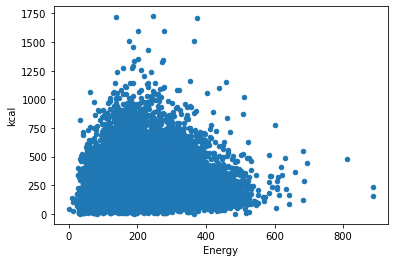

In [1774]:
df_mrgd_allrec[['Energy', 'kcal']].plot.scatter(x='Energy', y='kcal')

<AxesSubplot:xlabel='Energy', ylabel='kcal'>

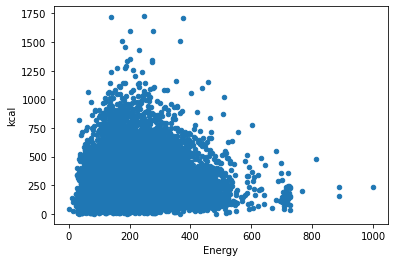

In [1719]:
df_mrgd_allrec[['Energy', 'kcal']].plot.scatter(x='Energy', y='kcal')

In [1784]:
df_mrgd_allrec[df_mrgd_allrec.kcal == np.inf]

,clean_title,kcal,carb,fat,prot,sodium,chol,Energy,Water,"Carbohydrate, by difference",Protein,Total lipid (fat),"Fiber, total dietary","Sugars, total including NLEA",Cholesterol,"Alcohol, ethyl",Caffeine,"Vitamin C, total ascorbic acid",Vitamin D (D2 + D3),diff


In [1787]:
df_mrgd_allrec['diff'] = (df_mrgd_allrec['kcal'] - df_mrgd_allrec['Energy']).astype(float)

In [1788]:
df_mrgd_allrec.nsmallest(5, 'diff')

,clean_title,kcal,carb,fat,prot,sodium,chol,Energy,Water,"Carbohydrate, by difference",Protein,Total lipid (fat),"Fiber, total dietary","Sugars, total including NLEA",Cholesterol,"Alcohol, ethyl",Caffeine,"Vitamin C, total ascorbic acid",Vitamin D (D2 + D3),diff
4253,grapeseed oil crust,159.0,60.0,93.6,6.4,18.0,0.0,887.2,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-728.2
4867,infused olive oil,239.0,0.4,243.0,0.0,56.0,0.0,887.2,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-648.2
4754,hot and spicy pecans,118.0,10.4,109.8,6.0,62.0,4.0,682.2,3.242,17.1,8.444,69.46,8.84,8.0,0.0,0.0,0.0,1.02,0.0,-564.2
6587,pecan sandies,90.0,35.2,53.1,3.6,61.0,4.0,641.8,6.406,20.82,8.39,62.8,8.04,9.32,17.8,0.0,0.0,0.92,0.1,-551.8
4603,herb cheese butter,54.0,0.8,53.1,1.2,99.0,16.0,604.8,18.568,17.312,3.186,59.98,0.68,11.576,21.0,0.0,0.0,0.06,0.1,-550.8


In [1779]:
results_allrecipes['cinnamon-roasted almonds']['matches'][['name', 'Energy']]

,name,Energy
4,"Nuts, almonds, dry roasted, with salt added",620.0
2208,"Almonds, honey roasted",579.0
2249,"Walnuts, honey roasted",617.0
1090,"Nuts, almonds, oil roasted, lightly salted",607.0
1907,"Nuts, almonds, oil roasted, with salt added",607.0


In [1743]:
food_data_cooked[food_data_cooked.name == 'Nuts, almonds, dry roasted, with salt added'][['name', 'Energy', 'data_source']]

,name,Energy,data_source
4,"Nuts, almonds, dry roasted, with salt added",2590.0,foundation


In [1725]:
df_mrgd_allrec.nsmallest(5, 'diff')

,clean_title,kcal,carb,fat,prot,sodium,chol,Energy,Water,"Carbohydrate, by difference",Protein,Total lipid (fat),"Fiber, total dietary","Sugars, total including NLEA",Cholesterol,"Alcohol, ethyl",Caffeine,"Vitamin C, total ascorbic acid",Vitamin D (D2 + D3),diff
2385,cinnamon-roasted almonds,231.0,53.2,162.0,31.2,40.0,0.0,1000.0,2.436,23.66,17.42,53.48,8.76,14.4,0.0,0.0,0.0,0.18,0.0,-769.0
4253,grapeseed oil crust,159.0,60.0,93.6,6.4,18.0,0.0,887.2,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-728.2
6143,oatmeal chocolate chip cookies iv,36.0,22.8,12.6,1.6,26.0,0.0,728.0,6.122,68.06,5.734,18.76,2.98,30.6,0.0,0.0,8.666667,0.3,0.0,-692.0
5203,lacy oatmeal cookies,44.0,23.6,18.9,1.6,55.0,9.0,708.4,8.23,67.9,6.014,16.08,2.925,29.6,3.75,0.0,0.0,0.2,0.0,-664.4
2261,chocolate oatmeal cookies,79.0,44.4,32.4,4.4,92.0,6.0,728.0,6.122,68.06,5.734,18.76,2.98,30.6,0.0,0.0,8.666667,0.3,0.0,-649.0


<AxesSubplot:>

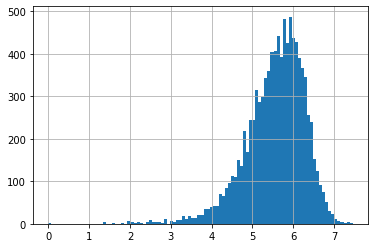

In [1723]:
np.log1p(df_mrgd_allrec['kcal']).hist(bins=100)


In [1083]:
df_allrecipes[df_allrecipes.clean_title == 'a southern fried chicken'].url.values

array(['http://allrecipes.com/Recipe/a-southern-fried-chicken/detail.aspx'],
      dtype=object)

In [2186]:
toy_example = lookup_all_nutrition_vectors_sent_trans(['chicken with broccoli'], embedded_db_loc=embedded_db_rev_dict, columns=columns, title_col='title_simple_reversed')

In [2198]:
toy_example['chicken with broccoli']['matches'][['title_simple_reversed', 'Energy', 'Protein']]

,title_simple_reversed,Energy,Protein
1092,chicken with gravy,129.0,18.90
1103,chicken with mole sauce,137.0,19.00
1207,biryani with chicken,104.0,7.15
1414,beef and broccoli,160.0,10.40
4776,junior broccoli and chicken dinner babyfood,62.0,3.59


# foodcom

In [2033]:
all_titles = set(df_filtered.clean_title)
data_exists = set(title for title in df_foodcom.clean_title if title in all_titles)

### highest possible nutrition: 900g/kcal - thta would encompass just FAT

In [1915]:
from sklearn.metrics import mean_squared_error, median_absolute_error

df_foodcom = pd.read_csv('food_data/west/foodcom_sample.csv', index_col=0)
foodcom_cj = pd.read_csv('food_data/west/foodcom_food_nutrition.csv')

In [2274]:
df_foodcom_grouped = df_foodcom.groupby('clean_title').mean().reset_index()

In [ ]:
results_foodcom_rev = lookup_all_nutrition_vectors_sent_trans(df_foodcom.clean_title.values, embedded_db_loc=embedded_db_rev_dict, columns=columns, title_col='title_simple_reversed')
df_foodcom_rev = transform_nut_dict_to_df(results_foodcom_rev, columns=columns, prefix='')

df_mrgd_foodcom_rev = df_foodcom_grouped.merge(df_foodcom_rev, on='clean_title', how='left').merge(foodcom_cj[['clean_title', 'calories', 'carbohydrates_total_g', 'protein_g']].drop_duplicates(), on = 'clean_title', how='left').copy()
df_mrgd_foodcom_rev = df_mrgd_foodcom_rev[(df_mrgd_foodcom_rev.kcal_100g < 900) & (df_mrgd_foodcom_rev.kcal_100g > 30)] # max calories = 900

df_mrgd_foodcom_rev= df_mrgd_foodcom_rev[~pd.isna(df_mrgd_foodcom_rev['kcal_100g']) & ~pd.isna(df_mrgd_foodcom_rev.calories)]
df_mrgd_foodcom_rev.Energy = df_mrgd_foodcom_rev.Energy.astype(float)

In [ ]:
results_foodcom_1 = lookup_all_nutrition_vectors_sent_trans(df_foodcom.clean_title.values, embedded_db_loc=embedded_db_rev_dict, columns=columns, title_col='title_simple_reversed', n=1)
df_foodcom_mean_1 = transform_nut_dict_to_df(results_foodcom_1, columns=columns, prefix='')

results_foodcom_3 = lookup_all_nutrition_vectors_sent_trans(df_foodcom.clean_title.values, embedded_db_loc=embedded_db_rev_dict, columns=columns, title_col='title_simple_reversed', n=3)
df_foodcom_mean_3 = transform_nut_dict_to_df(results_foodcom_3, columns=columns, prefix='')

results_foodcom_7 = lookup_all_nutrition_vectors_sent_trans(df_foodcom.clean_title.values, embedded_db_loc=embedded_db_rev_dict, columns=columns, title_col='title_simple_reversed', n=7)
df_foodcom_mean_7 = transform_nut_dict_to_df(results_foodcom_7, columns=columns, prefix='')

In [ ]:
df_mrgd_foodcom_1 = df_foodcom_grouped.merge(df_foodcom_mean_1, on='clean_title').merge(foodcom_cj[['clean_title', 'calories', 'carbohydrates_total_g', 'protein_g']], on = 'clean_title')
df_mrgd_foodcom_1= df_mrgd_foodcom_1[(df_mrgd_foodcom_1.kcal_100g < 900) & (df_mrgd_foodcom_1.kcal_100g > 30) &
                                     ~pd.isna(df_mrgd_foodcom_1['kcal_100g']) & ~pd.isna(df_mrgd_foodcom_1.calories)]
df_mrgd_foodcom_1.Energy = df_mrgd_foodcom_1.Energy.astype(float)
df_mrgd_foodcom_1[['kcal_100g', 'Energy']].corr('pearson')

df_mrgd_foodcom_3 = df_foodcom_grouped.merge(df_foodcom_mean_3, on='clean_title').merge(foodcom_cj[['clean_title', 'calories', 'carbohydrates_total_g', 'protein_g']], on = 'clean_title')
df_mrgd_foodcom_3= df_mrgd_foodcom_3[(df_mrgd_foodcom_3.kcal_100g < 900) & (df_mrgd_foodcom_3.kcal_100g > 30) &
                                     ~pd.isna(df_mrgd_foodcom_3['kcal_100g']) & ~pd.isna(df_mrgd_foodcom_3.calories)]
df_mrgd_foodcom_3.Energy = df_mrgd_foodcom_3.Energy.astype(float)
df_mrgd_foodcom_3[['kcal_100g', 'Energy']].corr('pearson')


In [2228]:
df_mrgd_foodcom_7 = df_foodcom_grouped.merge(df_foodcom_mean_7, on='clean_title').merge(foodcom_cj[['clean_title', 'calories', 'carbohydrates_total_g', 'protein_g']], on = 'clean_title')
df_mrgd_foodcom_7= df_mrgd_foodcom_7[(df_mrgd_foodcom_7.kcal_100g < 900) & (df_mrgd_foodcom_7.kcal_100g > 30) &
                                     ~pd.isna(df_mrgd_foodcom_7['kcal_100g']) & ~pd.isna(df_mrgd_foodcom_7.calories)]
df_mrgd_foodcom_7.Energy = df_mrgd_foodcom_7.Energy.astype(float)
df_mrgd_foodcom_7[['kcal_100g', 'Energy']].corr('pearson')

,kcal_100g,Energy
kcal_100g,1.0000,0.4995
Energy,0.4995,1.0000


In [ ]:
results_foodcom_9 = lookup_all_nutrition_vectors_sent_trans(df_foodcom.clean_title.values, embedded_db_loc=embedded_db_rev_dict, columns=columns, title_col='title_simple_reversed', n=9)
df_foodcom_mean_9 = transform_nut_dict_to_df(results_foodcom_9, columns=columns, prefix='')

In [2254]:
df_mrgd_foodcom_9 = df_foodcom_grouped.merge(df_foodcom_mean_9, on='clean_title').merge(foodcom_cj[['clean_title', 'calories', 'carbohydrates_total_g', 'protein_g']], on = 'clean_title')
df_mrgd_foodcom_9= df_mrgd_foodcom_9[(df_mrgd_foodcom_9.kcal_100g < 900) & (df_mrgd_foodcom_9.kcal_100g > 30) &
                                     ~pd.isna(df_mrgd_foodcom_9['kcal_100g']) & ~pd.isna(df_mrgd_foodcom_9.calories)]
df_mrgd_foodcom_9.Energy = df_mrgd_foodcom_9.Energy.astype(float)
df_mrgd_foodcom_9[['kcal_100g', 'Energy']].corr('pearson')

,kcal_100g,Energy
kcal_100g,1.000000,0.501678
Energy,0.501678,1.000000


In [2266]:
results_foodcom_50 = lookup_all_nutrition_vectors_sent_trans(df_foodcom.clean_title.values, embedded_db_loc=embedded_db_rev_dict, columns=columns, title_col='title_simple_reversed', n=50)


In [2256]:
results_foodcom_11 = lookup_all_nutrition_vectors_sent_trans(df_foodcom.clean_title.values, embedded_db_loc=embedded_db_rev_dict, columns=columns, title_col='title_simple_reversed', n=11)
df_foodcom_mean_11 = transform_nut_dict_to_df(results_foodcom_11, columns=columns, prefix='')
df_mrgd_foodcom_11 = df_foodcom_grouped.merge(df_foodcom_mean_11, on='clean_title').merge(foodcom_cj[['clean_title', 'calories', 'carbohydrates_total_g', 'protein_g']], on = 'clean_title')
df_mrgd_foodcom_11= df_mrgd_foodcom_11[(df_mrgd_foodcom_11.kcal_100g < 900) & (df_mrgd_foodcom_11.kcal_100g > 30) &
                                     ~pd.isna(df_mrgd_foodcom_11['kcal_100g']) & ~pd.isna(df_mrgd_foodcom_11.calories)]
df_mrgd_foodcom_11.Energy = df_mrgd_foodcom_11.Energy.astype(float)
df_mrgd_foodcom_11[['kcal_100g', 'Energy']].corr('pearson')

,kcal_100g,Energy
kcal_100g,1.000000,0.503112
Energy,0.503112,1.000000


In [2257]:
results_foodcom_15 = lookup_all_nutrition_vectors_sent_trans(df_foodcom.clean_title.values, embedded_db_loc=embedded_db_rev_dict, columns=columns, title_col='title_simple_reversed', n=15)
df_foodcom_mean_15 = transform_nut_dict_to_df(results_foodcom_15, columns=columns, prefix='')
df_mrgd_foodcom_15 = df_foodcom_grouped.merge(df_foodcom_mean_15, on='clean_title').merge(foodcom_cj[['clean_title', 'calories', 'carbohydrates_total_g', 'protein_g']], on = 'clean_title')
df_mrgd_foodcom_15= df_mrgd_foodcom_15[(df_mrgd_foodcom_15.kcal_100g < 900) & (df_mrgd_foodcom_15.kcal_100g > 30) &
                                     ~pd.isna(df_mrgd_foodcom_15['kcal_100g']) & ~pd.isna(df_mrgd_foodcom_15.calories)]
df_mrgd_foodcom_15.Energy = df_mrgd_foodcom_15.Energy.astype(float)
df_mrgd_foodcom_15[['kcal_100g', 'Energy']].corr('pearson')

,kcal_100g,Energy
kcal_100g,1.000000,0.505093
Energy,0.505093,1.000000


In [2046]:
results_fc_rev_median = compute_metric_vals_for_dict(results_foodcom_rev, columns=columns, metric='median')
df_fc_median = transform_nut_dict_to_df(results_fc_rev_median, columns=columns, prefix='')

df_mrgd_fc_rev_median = df_foodcom_grouped.merge(df_fc_median, on='clean_title', how='left').merge(foodcom_cj[['clean_title', 'calories', 'carbohydrates_total_g', 'protein_g']].drop_duplicates(), on = 'clean_title', how='left').copy()
df_mrgd_fc_rev_median = df_mrgd_fc_rev_median[(df_mrgd_fc_rev_median.kcal_100g < 900) & (df_mrgd_fc_rev_median.kcal_100g > 30)] # max calories = 900

df_mrgd_fc_rev_median= df_mrgd_fc_rev_median[~pd.isna(df_mrgd_fc_rev_median['kcal_100g']) & ~pd.isna(df_mrgd_fc_rev_median.calories)]
df_mrgd_fc_rev_median.Energy = df_mrgd_fc_rev_median.Energy.astype(float)

In [2211]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [2238]:
def plot_hist(df):
    all_cols = []
    for col in ['kcal_100g', 'Energy', 'calories']:
        df_part = df[[col]].copy()
        df_part['value'] = df[col]
        df_part['label'] = col
        all_cols.append(df_part[['value', 'label']])
    df_cols_combed = pd.concat(all_cols).reset_index(drop=True)

    sns.histplot(data=df_cols_combed, x='value', hue='label', bins=100)
    
def calc_errors(df_err, col, orig_col = 'kcal_100g', return_err=False):
    df_err[f'diff_{col}'] = df_err[orig_col] - df_err[col]
    df_err[f'diff_abs_{col}'] = np.abs(df_err[f'diff_{col}'])
    df_err[f'diff_squ_{col}'] = df_err[f'diff_{col}'] ** 2
    print(f'MedAE for {orig_col} and {col}', np.median(df_err[f'diff_abs_{col}']))
    print(f'MSE for {orig_col} and {col}', np.mean(df_err[f'diff_squ_{col}']))
    return df_err if return_err else None
    
def calc_errors_bs(df_err, col, orig_col='kcal_100g'):
    df_err = calc_errors(df_err, col, orig_col)
    df_err.Energy

In [2217]:
bs_CI = bs.bootstrap(df_mrgd_foodcom_rev.Energy.values, stat_func=bs_stats.mean, num_iterations=10000, num_threads=10)

In [2222]:
bs_CI_foodcom = bs.bootstrap(df_mrgd_foodcom_rev.kcal_100g.values, stat_func=bs_stats.mean, num_iterations=10000, num_threads=10)


In [2219]:
bs_CI_calories = bs.bootstrap(df_mrgd_foodcom_rev.calories.values, stat_func=bs_stats.mean, num_iterations=10000, num_threads=10)

In [2223]:
print('estimated', bs_CI)
print('foodcom', bs_CI_foodcom)
print('calories', bs_CI_calories)

estimated 216.75267680724565    (214.45429917694617, 219.03707816997277)
foodcom 210.82967862764133    (207.966892541941, 213.67273246890784)
calories 207.89159529366006    (205.23816492609882, 210.50144674737456)


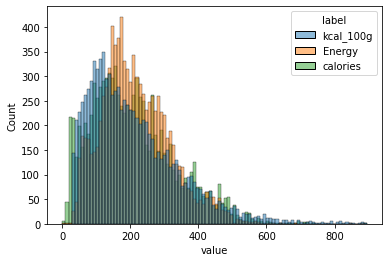

In [2259]:
plot_hist(df_mrgd_foodcom_15)

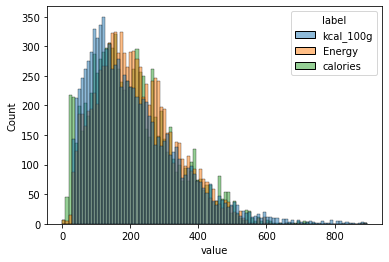

In [2080]:
plot_hist(df_mrgd_foodcom_3)

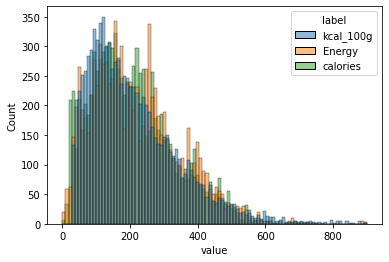

In [2079]:
plot_hist(df_mrgd_foodcom_1)

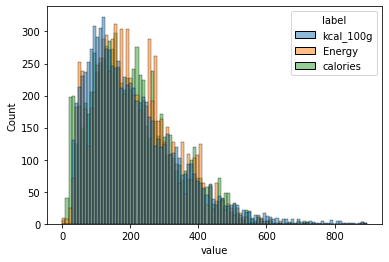

In [2057]:
plot_hist(df_mrgd_fc_rev_median)

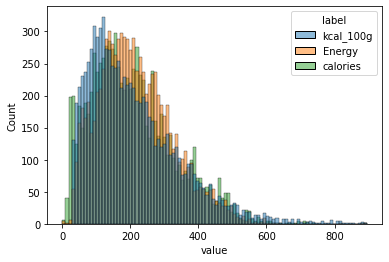

In [2058]:
plot_hist(df_mrgd_foodcom_rev)

<AxesSubplot:xlabel='value', ylabel='label'>

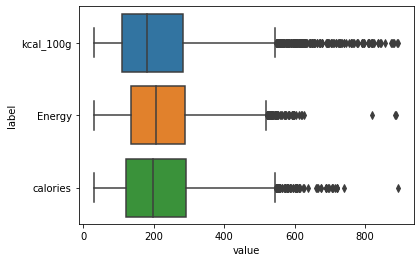

In [1981]:
sns.boxplot(data=df_cols_combed[(df_cols_combed.value < 1000) & (df_cols_combed.value >30)], x='value', y='label')

In [2094]:
calc_errors(df_mrgd_foodcom_1.copy(), 'Energy')
print('Only overlapping data')
calc_errors(df_mrgd_foodcom_1[df_mrgd_foodcom_1.clean_title.isin(data_exists)].copy(), 'Energy')

MedAE for kcal_100g and Energy 68.67441860465121
MSE for kcal_100g and Energy 19297.071537888383
Only overlapping data
MedAE for kcal_100g and Energy 65.68803418803418
MSE for kcal_100g and Energy 16503.127237754572


In [2095]:
calc_errors(df_mrgd_foodcom_3.copy(), 'Energy')
print('Only overlapping data')
calc_errors(df_mrgd_foodcom_3[df_mrgd_foodcom_3.clean_title.isin(data_exists)].copy(), 'Energy')

MedAE for kcal_100g and Energy 63.956639566395665
MSE for kcal_100g and Energy 16060.050383867901
Only overlapping data
MedAE for kcal_100g and Energy 63.94551282051283
MSE for kcal_100g and Energy 13339.083569263306


In [2239]:
calc_errors(df_mrgd_foodcom_7.copy(), 'Energy')
print('Only overlapping data')
calc_errors(df_mrgd_foodcom_7[df_mrgd_foodcom_7.clean_title.isin(data_exists)].copy(), 'Energy')

MedAE for kcal_100g and Energy 62.291666666666664
MSE for kcal_100g and Energy 15084.026436550685
Only overlapping data
MedAE for kcal_100g and Energy 63.227848101265806
MSE for kcal_100g and Energy 12588.69348483613


In [2253]:
calc_errors(df_mrgd_foodcom_9.copy(), 'Energy')
print('Only overlapping data')
calc_errors(df_mrgd_foodcom_9[df_mrgd_foodcom_9.clean_title.isin(data_exists)].copy(), 'Energy')

MedAE for kcal_100g and Energy 62.076628352490445
MSE for kcal_100g and Energy 14882.283003745919
Only overlapping data
MedAE for kcal_100g and Energy 65.98381785680685
MSE for kcal_100g and Energy 12469.010928787178


In [2252]:
calc_errors(df_mrgd_foodcom_11.copy(), 'Energy')
print('Only overlapping data')
calc_errors(df_mrgd_foodcom_11[df_mrgd_foodcom_11.clean_title.isin(data_exists)].copy(), 'Energy')

MedAE for kcal_100g and Energy 62.076628352490445
MSE for kcal_100g and Energy 14882.283003745919
Only overlapping data
MedAE for kcal_100g and Energy 65.98381785680685
MSE for kcal_100g and Energy 12469.010928787178


In [2258]:
calc_errors(df_mrgd_foodcom_15.copy(), 'Energy')
print('Only overlapping data')
calc_errors(df_mrgd_foodcom_15[df_mrgd_foodcom_15.clean_title.isin(data_exists)].copy(), 'Energy')

MedAE for kcal_100g and Energy 61.85128205128203
MSE for kcal_100g and Energy 14624.484305251994
Only overlapping data
MedAE for kcal_100g and Energy 61.954545454545496
MSE for kcal_100g and Energy 12113.931967456092


In [2265]:
calc_errors(df_mrgd_foodcom_15.copy(), 'const_median')
print('Only overlapping data')
calc_errors(df_mrgd_foodcom_15[df_mrgd_foodcom_15.clean_title.isin(data_exists)].copy(), 'const_median')

MedAE for kcal_100g and const_median 81.44234533354597
MSE for kcal_100g and const_median 18988.060816264093
Only overlapping data
MedAE for kcal_100g and const_median 74.88415955142094
MSE for kcal_100g and const_median 17172.96531560093


In [2263]:
df_mrgd_foodcom_15['const_mean'] = df_mrgd_foodcom_15.kcal_100g.mean()
df_mrgd_foodcom_15['const_median'] = df_mrgd_foodcom_15.kcal_100g.median()

In [2264]:
df_mrgd_foodcom_15['const_median']

0        180.484262
1        180.484262
2        180.484262
3        180.484262
4        180.484262
            ...    
10335    180.484262
10337    180.484262
10338    180.484262
10339    180.484262
10340    180.484262
Name: const_median, Length: 9305, dtype: float64

In [2251]:
results_foodcom_11['7 layer bean dip']['matches']

,name,parent_name,"Cryptoxanthin, beta",Lycopene,"Tocopherol, delta","Tocotrienol, gamma","Tocotrienol, delta","Vitamin C, total ascorbic acid",Thiamin,Riboflavin,...,PUFA 20:3 n-6,"Fluoride, F",PUFA 18:2 i,SFA 13:0,Phytosterols,PUFA 2:4 n-6,MUFA 18:1-11 t (18:1t n-7),bow,title_simple,title_simple_reversed
265,"Onion dip, light","Dips, gravies, other sauces",1.0,0.0,NaN,NaN,NaN,0.9,0.030,0.067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Onion dip, light]",onion dip light,light onion dip
268,"Spinach dip, regular","Dips, gravies, other sauces",2.0,0.0,NaN,NaN,NaN,0.5,0.026,0.106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Spinach dip, regular]",spinach dip regular,regular spinach dip
269,"Spinach dip, light","Dips, gravies, other sauces",1.0,0.0,NaN,NaN,NaN,0.5,0.032,0.078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Spinach dip, light]",spinach dip light,light spinach dip
270,"Vegetable dip, regular","Dips, gravies, other sauces",2.0,0.0,NaN,NaN,NaN,1.7,0.017,0.114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Vegetable dip, regular]",vegetable dip regular,regular vegetable dip
271,"Vegetable dip, light","Dips, gravies, other sauces",1.0,0.0,NaN,NaN,NaN,1.6,0.024,0.079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Vegetable dip, light]",vegetable dip light,light vegetable dip
2115,"Bean dip, made with refried beans","Dips, gravies, other sauces",0.0,0.0,NaN,NaN,NaN,0.6,0.090,0.100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Bean dip, made with refried beans]",bean dip made with refried beans,made with refried beans bean dip
2124,Bean cake,"Bean, pea, legume dishes",0.0,0.0,NaN,NaN,NaN,0.3,0.268,0.139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Bean cake],bean cake,bean cake
2143,Bean chips,"Tortilla, corn, other chips",0.0,0.0,NaN,NaN,NaN,1.7,0.499,0.153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Bean chips],bean chips,bean chips
5095,Dessert dip,"Jams, syrups, toppings",1.0,0.0,NaN,NaN,NaN,0.0,0.025,0.199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Dessert dip],dessert dip,dessert dip
4320,"Dip, bean, original flavor","Dip, bean, original flavor",0.0,0.0,NaN,NaN,NaN,0.6,0.090,0.100,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Dip, bean, original flavor]",dip bean original flavor,original flavor bean dip


In [2060]:
calc_errors(df_mrgd_fc_rev_median, 'calories')
calc_errors(df_mrgd_fc_rev_median, 'Energy')
print('Only overlapping data')
calc_errors(df_mrgd_fc_rev_median[df_mrgd_fc_rev_median.clean_title.isin(data_exists)].copy(), 'calories')
calc_errors(df_mrgd_fc_rev_median[df_mrgd_fc_rev_median.clean_title.isin(data_exists)].copy(), 'Energy')

MedAE for kcal_100g and calories 62.61756513926329
MSE for kcal_100g and calories 16536.62434233101
MedAE for kcal_100g and Energy 63.1367303609342
MSE for kcal_100g and Energy 16906.751848522308
Only overlapping data
MedAE for kcal_100g and calories 62.29289215686272
MSE for kcal_100g and calories 14391.260183730099
MedAE for kcal_100g and Energy 64.99619036455279
MSE for kcal_100g and Energy 14217.034968673977


In [2225]:
calc_errors(df_mrgd_foodcom_rev, 'calories')
calc_errors(df_mrgd_foodcom_rev, 'Energy')
print('Only overlapping data')
calc_errors(df_mrgd_foodcom_rev[df_mrgd_foodcom_rev.clean_title.isin(data_exists)].copy(), 'calories')
calc_errors(df_mrgd_foodcom_rev[df_mrgd_foodcom_rev.clean_title.isin(data_exists)].copy(), 'Energy')

MedAE for kcal_100g and calories 62.61756513926329
MSE for kcal_100g and calories 16536.62434233101
MedAE for kcal_100g and Energy 63.54109453089001
MSE for kcal_100g and Energy 15579.304262108439
Only overlapping data
MedAE for kcal_100g and calories 62.29289215686272
MSE for kcal_100g and calories 14391.260183730099
MedAE for kcal_100g and Energy 64.73244969658256
MSE for kcal_100g and Energy 13156.05931486129


,clean_title,kcal,carb,fat,prot,sodium,chol,ss_clean,factor_100g,kcal_100g,...,diff_cals,diff_calories,diff_abs_calories,diff_squ_calories,diff_Energy,diff_abs_Energy,diff_squ_Energy,diff_kcal_100g,diff_abs_kcal_100g,diff_squ_kcal_100g
47,15 layer russian honey cake,282.40,125.6,145.8,14.8,183.10,46.60,94.0,0.94,300.425532,...,-27.774468,-27.584468,27.584468,760.902880,-27.774468,27.774468,771.421077,0.0,0.0,0.0
89,7 layer bean dip,452.65,70.6,326.7,70.0,775.45,68.95,184.0,1.84,244.020935,...,50.220935,125.420935,125.420935,15730.410993,50.220935,50.220935,2522.142335,0.0,0.0,0.0
90,7 layer dip,138.40,44.4,77.4,21.2,752.30,21.50,120.0,1.20,115.333333,...,-133.066667,-171.766667,171.766667,29503.787778,-133.066667,133.066667,17706.737778,0.0,0.0,0.0
134,alfajores de maizena,364.70,202.0,148.5,10.4,226.60,87.80,61.0,0.61,597.868852,...,243.068852,286.268852,286.268852,81949.855888,243.068852,243.068852,59082.467036,0.0,0.0,0.0
136,alfredo sauce,489.90,10.0,453.6,34.4,312.40,159.00,107.0,1.07,457.850467,...,247.850467,22.950467,22.950467,526.723949,247.850467,247.850467,61429.854136,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9724,yellow chicken curry,1585.90,1079.6,331.2,166.8,266.80,72.60,670.0,6.70,236.701493,...,134.701493,130.401493,130.401493,17004.549256,134.701493,134.701493,18144.492092,0.0,0.0,0.0
9788,zucchini bread,358.20,168.8,176.4,16.0,431.30,46.50,89.0,0.89,402.471910,...,115.671910,8.371910,8.371910,70.088879,115.671910,115.671910,13379.990789,0.0,0.0,0.0
9793,zucchini fritters,96.60,17.6,60.3,18.8,263.40,59.70,58.0,0.58,166.551724,...,-195.281609,26.851724,26.851724,721.015089,-195.281609,195.281609,38134.906890,0.0,0.0,0.0
9801,zucchini pancakes,362.90,87.2,241.2,38.0,831.70,216.50,165.0,1.65,219.939394,...,-50.660606,36.239394,36.239394,1313.293673,-50.660606,50.660606,2566.497006,0.0,0.0,0.0


In [2075]:
calc_errors(df_mrgd_foodcom_rev.copy(), 'calories', 'Energy')
calc_errors(df_mrgd_foodcom_rev[df_mrgd_foodcom_rev.clean_title.isin(data_exists)].copy(), 'calories', 'Energy')

MedAE for Energy and calories 47.35000000000001
MSE for Energy and calories 7798.354253797369
MedAE for Energy and calories 43.7
MSE for Energy and calories 6941.28152460543


<AxesSubplot:xlabel='kcal_100g', ylabel='Energy'>

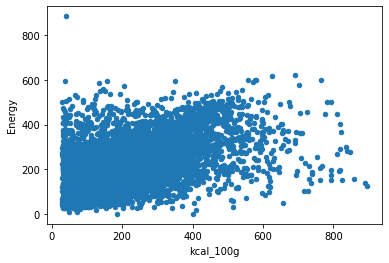

In [1991]:
df_mrgd_foodcom_rev[df_mrgd_foodcom_rev.kcal < 900][['Energy', 'kcal_100g']].plot.scatter(x='kcal_100g', y='Energy')

<AxesSubplot:xlabel='kcal_100g', ylabel='Energy'>

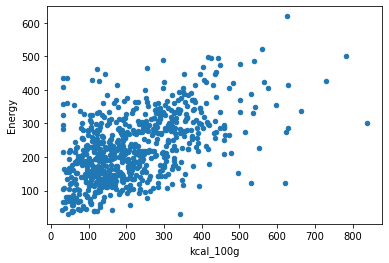

In [2039]:
df_mrgd_foodcom_rev[df_mrgd_foodcom_rev.clean_title.isin(data_exists)][['kcal_100g', 'Energy']].plot.scatter(x='kcal_100g', y='Energy')

<AxesSubplot:xlabel='calories', ylabel='Energy'>

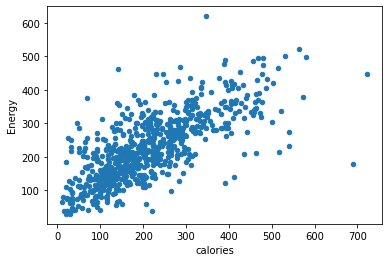

In [2043]:
df_mrgd_foodcom_rev[df_mrgd_foodcom_rev.clean_title.isin(data_exists)][['calories', 'Energy']].plot.scatter(x='calories', y='Energy')

In [1937]:
df_mrgd_foodcom_rev['diff_cals'] = df_mrgd_foodcom_rev.kcal_100g - df_mrgd_foodcom_rev.Energy

In [2028]:
df_mrgd_foodcom_rev.nsmallest(10, 'diff_cals')[['clean_title', 'Energy', 'kcal_100g', 'diff_cals']]

,clean_title,Energy,kcal_100g,diff_cals
6033,mullein garlic ear oil,884.0,39.411765,-844.588235
7564,roasted salted sunflower seed,596.0,37.616865,-558.383135
3003,dipping oil for bread,821.0,290.876404,-530.123596
151,almond butter cookies vegan,501.2,30.542169,-470.657831
6012,mounds candy bar brownies,516.8,49.833887,-466.966113
6221,nori roasted seaweed) cheese snacks,532.2,66.170213,-466.029787
6984,popcorn seasoning mixes,504.0,41.676647,-462.323353
6395,orange or lemon) infused olive oil,887.2,425.209205,-461.990795
2917,dehydrator ' sour cream onion' potato chips,525.2,70.743243,-454.456757
4701,"how to blanch, split, sliver almonds",585.6,134.607843,-450.992157


In [2027]:
df_mrgd_foodcom_rev.nlargest(10, 'diff_cals')[['clean_title', 'Energy', 'kcal_100g', 'diff_cals']]

,clean_title,Energy,kcal_100g,diff_cals
7228,quick polenta rounds with sage butter and parm...,127.6,894.736842,767.136842
7302,"raspberry dressing vinaigrette), no added sugar",140.6,891.111111,750.511111
8732,tartar sauce from scratch,135.8,878.021108,742.221108
2491,creamy italian salad dressing,155.4,857.619048,702.219048
4117,greek seasoning mix,151.0,825.625000,674.625000
5344,linda's spicy mayonnaise sauce for sushi,131.4,776.694915,645.294915
7741,sauteed shrimp and remoulade sauce over angel ...,156.8,796.398104,639.598104
1485,caramelized pineapple,154.4,793.076923,638.676923
4527,hoisin sauce,209.6,843.014706,633.414706
2294,cornbread sweet moist,249.6,881.777778,632.177778


## AEK

In [1655]:
aek_sample = pd.read_csv('food_data/aek/food_diaries_mod.csv', index_col=0)


In [1994]:
cj_aek = pd.read_csv('food_data/aek/food_diary_nutrition.csv', index_col=0)

In [ ]:
results_aek = lookup_all_nutrition_vectors_sent_trans(aek_sample.clean_title.values, 
                                        embedded_db_loc=embedded_db_rev_dict, columns=columns,
                                        title_col='title_simple_reversed')

In [1941]:
df_aek = transform_nut_dict_to_df(results_aek, columns=columns, prefix='')

In [1998]:
cj_aek

,index,food,clean_title,calories_100g,grams,index.1,food_title,calories,carbohydrates_total_g,cholesterol_mg,fat_saturated_g,fat_total_g,fiber_g,potassium_mg,protein_g,sodium_mg,sugar_g
6,6,"homemade - deep fried five spices(ngor hiang),...",homemade deep fried five spices(ngor hiang),230.000000,100.00,0,homemade deep fried five spices(ngor hiang),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,"scotts - porridge, 20 g",scotts porridge,355.000000,20.00,1,scotts porridge,91.00,12.70,7.0,1.20,2.40,1.2,136.0,4.70,47.0,0.1
9,9,"bread white - bread white, 100 g",bread white bread white,247.000000,100.00,2,bread white bread white,261.55,49.25,0.0,0.70,3.35,2.7,96.5,8.85,489.0,5.6
17,17,"singapore hpb - lor mee, 1 bowl (540 g)",singapore hpb lor mee,70.555556,540.00,3,singapore hpb lor mee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,33,"rice - brown rice, 100 g",rice brown rice,118.000000,100.00,4,rice brown rice,111.00,23.30,0.0,0.20,0.80,1.8,76.0,2.30,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29376,29376,"sodexo campus - brown rice, 3.2 oz",sodexo campus brown rice,123.456790,90.72,4754,sodexo campus brown rice,110.00,23.10,0.0,0.20,0.80,1.8,77.0,2.30,0.0,0.0
29378,29378,"homemade - chicken curry & rice, 1 -2.5oz chic...",homemade chicken curry & rice,811.344716,70.87,4755,homemade chicken curry & rice,116.85,15.80,15.5,0.35,2.45,0.5,69.0,7.40,15.5,0.5
29383,29383,"rice bowl - rice, 45 g",rice bowl rice,355.555556,45.00,4756,rice bowl rice,125.45,18.80,12.0,0.65,3.15,0.8,81.5,5.95,116.0,0.7
29384,29384,"sweet potato, 0.5 cup (133 g)",sweet potato,42.857143,133.00,4757,sweet potato,77.50,17.50,0.0,0.00,0.10,2.5,32.0,1.40,26.0,5.8


In [2014]:
df_mrg_aek = cj_aek.merge(df_aek, on='clean_title', how='left')
df_mrg_aek = df_mrg_aek[(df_mrg_aek.calories_100g > 30) & (df_mrg_aek.calories_100g < 900)][['clean_title', 'calories_100g', 'calories', 'Energy']]
df_mrg_aek.Energy = df_mrg_aek.Energy.astype(float)

<AxesSubplot:xlabel='calories_100g', ylabel='Energy'>

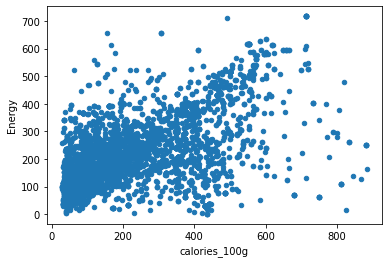

In [2015]:
df_mrg_aek[['calories_100g', 'Energy']].plot.scatter(x='calories_100g', y='Energy')

<AxesSubplot:xlabel='calories_100g', ylabel='calories'>

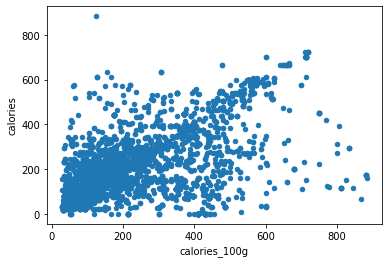

In [2016]:
df_mrg_aek[['calories_100g', 'calories']].plot.scatter(x='calories_100g', y='calories')

In [2003]:
df_mrg_aek['diff_abs'] = df_mrg_aek.calories_100g - df_mrg_aek.Energy

In [2018]:
df_mrg_aek[(df_mrg_aek.calories_100g > 30) & (df_mrg_aek.calories_100g < 900)][['calories_100g', 'calories', 'Energy']].corr()

,calories_100g,calories,Energy
calories_100g,1.000000,0.565462,0.508254
calories,0.565462,1.000000,0.717309
Energy,0.508254,0.717309,1.000000


### Epicurious

In [1629]:
epic_sample = pd.read_csv('food_data/epicurious/epi_clean.csv', index_col=0)
epic_sample.head()

,title,calories,protein,fat,sodium,clean_title
0,"Lentil, Apple, and Turkey Wrap",426.0,30.0,7.0,559.0,lentil apple and turkey wrap
1,Boudin Blanc Terrine with Red Onion Confit,403.0,18.0,23.0,1439.0,boudin blanc terrine with red onion confit
2,Potato and Fennel Soup Hodge,165.0,6.0,7.0,165.0,potato and fennel soup hodge
4,Spinach Noodle Casserole,547.0,20.0,32.0,452.0,spinach noodle casserole
5,The Best Blts,948.0,19.0,79.0,1042.0,the best blts


In [1951]:
%%time
results_epic = lookup_all_nutrition_vectors_sent_trans(epic_sample.clean_title.values, 
                                                       embedded_db_loc=embedded_db_rev_dict, columns=columns,
                                                       title_col='title_simple_reversed')

CPU times: user 2h 9min 41s, sys: 1min 4s, total: 2h 10min 46s
Wall time: 4min 30s


In [1952]:
df_epic = transform_nut_dict_to_df(results_epic, columns=columns, prefix='')

In [1633]:
df_epic[df_epic.clean_title.str.contains('chinese barbecued spareribs')].clean_title.values

array(['chinese barbecued spareribs'], dtype=object)

In [1953]:
results_epic['chinese barbecued spareribs']['similarity']

,title_simple_reversed,similarity
5976,lean and fat eaten with sauce barbecued sparer...,0.678674
5977,lean only eaten with sauce barbecued spareribs...,0.633105
5857,lean and fat eaten with sauce barbecued shortr...,0.610180
8482,beef and vegetables chinese restaurant,0.605699
8169,chicken and vegetables chinese restaurant,0.598109


In [1954]:
df_mrg_epic = epic_sample.merge(df_epic, on='clean_title', how='left')

In [1955]:
df_mrg_epic

,title,calories,protein,fat,sodium,clean_title,Energy,Water,"Carbohydrate, by difference",Protein,Total lipid (fat),"Fiber, total dietary","Sugars, total including NLEA",Cholesterol,"Alcohol, ethyl",Caffeine,"Vitamin C, total ascorbic acid",Vitamin D (D2 + D3)
0,"Lentil, Apple, and Turkey Wrap",426.0,30.0,7.0,559.0,lentil apple and turkey wrap,223.8,54.72,20.38,11.656,10.468,1.5,2.464,32.6,0.0,0.0,2.88,0.6
1,Boudin Blanc Terrine with Red Onion Confit,403.0,18.0,23.0,1439.0,boudin blanc terrine with red onion confit,131.8,74.56,8.362,8.044,7.366,1.08,1.4225,31.0,0.0,0.0,5.52,0.22
2,Potato and Fennel Soup Hodge,165.0,6.0,7.0,165.0,potato and fennel soup hodge,39.2,90.76,5.39,1.25,1.492,0.64,1.184,1.6,0.0,0.0,2.84,0.075
3,Spinach Noodle Casserole,547.0,20.0,32.0,452.0,spinach noodle casserole,142.0,69.18,17.982,6.706,4.85,2.025,1.3175,22.0,0.0,0.0,8.9,0.16
4,The Best Blts,948.0,19.0,79.0,1042.0,the best blts,128.0,73.946,14.62,1.594,1.854,1.18,6.225,1.4,8.35,10.2,1.82,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15859,Parmesan Puffs,28.0,2.0,2.0,64.0,parmesan puffs,394.4,19.508,45.262,14.652,18.172,1.36,7.9,38.6,0.0,0.0,0.0,1.34
15860,Artichoke and Parmesan Risotto,671.0,22.0,28.0,583.0,artichoke and parmesan risotto,176.4,67.14,16.292,4.876,10.25,1.24,2.536,24.4,0.0,0.0,4.075,0.225
15861,Turkey Cream Puff Pie,563.0,31.0,38.0,652.0,turkey cream puff pie,269.2,51.32,25.2,6.012,16.26,1.18,11.6475,28.8,0.0,0.25,0.75,0.35
15862,Snapper on Angel Hair with Citrus Cream,631.0,45.0,24.0,517.0,snapper on angel hair with citrus cream,152.6,70.12,14.758,6.078,8.11,1.16,9.635,22.0,0.0,0.0,7.96,2.925


<AxesSubplot:xlabel='calories', ylabel='Energy'>

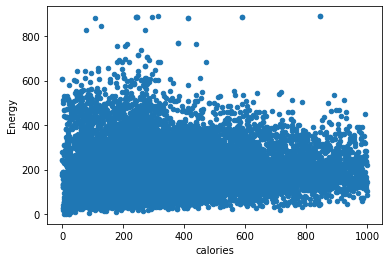

In [1959]:
df_mrg_epic[df_mrg_epic.calories<1000][['calories', 'Energy']].plot.scatter(x='calories', y='Energy')

In [1960]:
df_mrg_epic.Energy = df_mrg_epic.Energy.astype(float)
df_mrg_epic[df_mrg_epic.calories<1000][['calories', 'Energy']].corr()

,calories,Energy
calories,1.000000,0.024205
Energy,0.024205,1.000000
